<a href="https://colab.research.google.com/github/mminn94/Machine-Learning/blob/main/team_pj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
## 저번에 와르르 실행시키는 셀을 아래쪽에 만들었었는데
## 그게 더 번거로운 거 같아서 그냥 각 셀마다 넣어놨습니다!!
## 위에서부터 차례로 하나씩 하면 됩니다

##맨 처음에 꼭 content 폴더에 kaggle.json을 옮겨놔주세요. (원래 있는 sample_data폴더랑 형제가 되도록))

## 주요 수정 사항 ##
# 압축 해제한거를 굳이 새로 카피할 필요가 없어져서 르네상스_식민주의 폴더만 '르네상스'로 이름 변경 & 하위폴더에 식민주의 관련 파일들 삭제만 함
# 클래스별 500개씩 , 112x112사이즈



In [1]:
#설치 모음
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import random
import os # 'os' 라이브러리: 파일 경로를 다루거나, 디렉토리를 만들고, 파일 목록을 읽는 등 운영체제와 관련된 기능을 제공
from pathlib import Path
import shutil   # 'shutil' 라이브러리: 파일 복사, 이동, 삭제 등 파일 작업 도움

import matplotlib.pyplot as plt # 데이터를 그래프로 시각화
import matplotlib.image as mpimg
import pandas as pd # 데이터를 표(테이블) 형태로
from PIL import Image

In [9]:

root_path = Path('/content')
dataset_path = Path(root_path/'dataset') #데이터셋 폴더 경로
print(dataset_path)

/content/dataset


In [16]:
###리셋용 : 아마 쓸일 없을 텐데 쓴다면 필요한 부분만 주석 취소하고..
def reset():
  # shutil.rmtree("/content/dataset")
  # !rm -rf /content/
  !rm -rf /content/dataset/
  # !rm -rf /content/Capstone_Architectural_Styles_dataset/
  # !rm -rf /content/data/architectural-styles-periods-dataset.zip

  # print("기존 폴더 삭제 완료.")

reset()

In [17]:

### 캐글 api설치 ~ 데이터셋 다운,압축해제,압축파일삭제 ~ 폴더명변경
def InitialSettings():
  !pip install kaggle #kaggle 라이브러리 설치
  !mkdir -p ~/.kaggle #kaggle 폴더 생성
  !cp kaggle.json ~/.kaggle/ #폴더에 kaggle.json 파일 복사
  !chmod 600 ~/.kaggle/kaggle.json #kaggle.json 파일 권한 설정
  !kaggle datasets download -d gustavoachavez/architectural-styles-periods-dataset -p {root_path}  #데이터셋 다운로드
  !unzip {root_path}/architectural-styles-periods-dataset.zip -d {root_path}  #데이터셋 압축 해제

  !rm -rf {root_path}/sample_data #원래 있는 샘플데이터 폴더 삭제
  !rm -rf {root_path}/architectural-styles-periods-dataset.zip #압축zip파일 삭제
  !mv {root_path}/Capstone_Architectural_Styles_dataset {root_path}/dataset #파일명 dataset으로 변경

###실행
InitialSettings()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/Capstone_Architectural_Styles_dataset/Modernism/Chicago school architecture/5320.jpg  
  inflating: /content/Capstone_Architectural_Styles_dataset/Modernism/Chicago school architecture/53200.jpg  
  inflating: /content/Capstone_Architectural_Styles_dataset/Modernism/Chicago school architecture/53201.jpg  
  inflating: /content/Capstone_Architectural_Styles_dataset/Modernism/Chicago school architecture/53202.jpg  
  inflating: /content/Capstone_Architectural_Styles_dataset/Modernism/Chicago school architecture/53203.jpg  
  inflating: /content/Capstone_Architectural_Styles_dataset/Modernism/Chicago school architecture/53204.jpg  
  inflating: /content/Capstone_Architectural_Styles_dataset/Modernism/Chicago school architecture/53205.jpg  
  inflating: /content/Capstone_Architectural_Styles_dataset/Modernism/Chicago school architecture/53206.jpg  
  inflating: /content/Capstone_Architectural_Styles_dataset/Modernism/Chicago school 

In [21]:

## dataset 하위 디렉터리에서 식민주의 Colonialism 삭제 :
# 1) 이름변경 : Renaissance_and어쩌구 => Renaissance
# 2) 그 폴더 안에 식민주의 관련 파일 폴더 다 삭제 ('Colonial' or 'Georgian' 포함된 파일명)

def deleteColonialism():
  for class_path in dataset_path.iterdir():
    # print(class_path.name)
    if 'Renaissance' in class_path.name :
      !mv {class_path} {class_path.parent/'Renaissance'} #1) 폴더명 변경
      for Rene_child_path in class_path.iterdir():
        if ('Colonial' in Rene_child_path.name )or ('Georgian' in Rene_child_path.name):
          shutil.rmtree(Rene_child_path) #2) 폴더 안에 식민주의 관련 파일 폴더 다 삭제
  # print("--- 현재 폴더 구조 ---")
  # !find {dataset_path}/ -maxdepth 2 -type d -print


deleteColonialism()

mv: cannot move '/content/dataset/Renaissance' to a subdirectory of itself, '/content/dataset/Renaissance/Renaissance'


In [22]:
# 각 클래스 디렉토리의 하위 폴더 통합
def mergeChildDir():
  for class_path in dataset_path.iterdir(): #클래스 폴더 순회
    # print(class_path)
    for child_path in list(class_path.iterdir()): #하위 폴더 순회. list감싸서 나중에 변경 안 되도록
      if child_path.is_dir():
        # print(child_path)
        for img_file in child_path.iterdir(): #이미지 파일 순회
          destination_path = class_path/img_file.name #파일별 최종 경로 (클래스폴더/이미지파일.jpg)
          # print(destination_path)
          if destination_path.exists():
            print(f"!!!!!! Warning: '{destination_path.name}' 이미 있음.")
            continue # 건너뛰기
          shutil.move(str(img_file), str(destination_path)) # 파일 이동

        os.rmdir(child_path)


###실행
mergeChildDir();

In [23]:
# 폴더별 이미지 개수 확인 - 딕셔너리 형태 반환
def countImgsPerClass():
  class_img_counts = {}
  total_count = 0

  for class_dir in dataset_path.iterdir():
    # print(class_dir.name)

    if class_dir.is_dir(): #isdir : '파일'이 아니라 '폴더'가 맞는지 확인
      # print(class_dir.name)
      count = len(list(class_dir.iterdir()))
      # print(count)
      class_img_counts[class_dir.name]=count
      total_count+=count

  # print("총 이미지 개수:",total_count)
  # print("클래스별 이미지 개수:",class_img_counts)
  return class_img_counts

###실행
countImgsPerClass()

{'Neoclassicism': 1225,
 'Renaissance': 521,
 '21st_Century': 1229,
 'Early_Christian_Medieval': 1338,
 'Baroque': 1089,
 'Revivalism': 1919,
 'Eclecticism': 1315,
 'Modernism': 1860,
 'Classical': 1022}

                      class  count
0             Neoclassicism   1225
1               Renaissance    521
2              21st_Century   1229
3  Early_Christian_Medieval   1338
4                   Baroque   1089
5                Revivalism   1919
6               Eclecticism   1315
7                 Modernism   1860
8                 Classical   1022


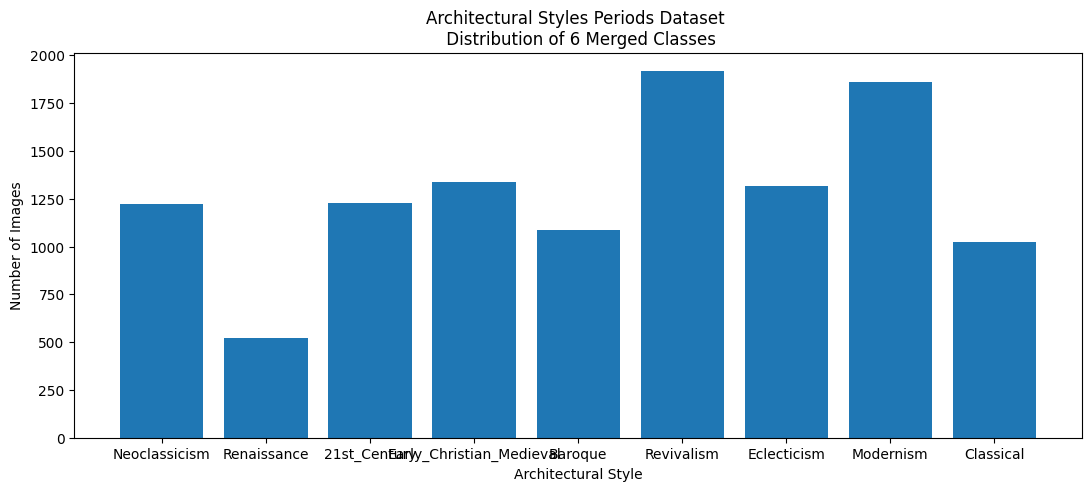

In [24]:
####EDA 1  : 클래스 분포 확인
def showClassDistribution():
  class_img_counts = countImgsPerClass()
  # plt.rcdefaults()
  #pd.DataFrame : 리스트나 딕셔너리 데이터를 표로 만들어줌
  # 딕셔너리의 .items()를 사용해 (키, 값) 쌍의 리스트로 변환
  data_count_table = pd.DataFrame(class_img_counts.items(), columns=['class', 'count'])
  print(data_count_table)

  #plt : 표를 그래프로 시각화
  plt.figure(figsize=(13,5)) #캔버스 크기
  #plt.bar : 막대그래프 (x축, y축)
  plt.bar(data_count_table['class'], data_count_table['count'])

  plt.title("Architectural Styles Periods Dataset \n Distribution of 6 Merged Classes") #건축 양식 이미지 데이터셋 / 6개 건축 양식 클래스별 데이터 분포
  plt.xlabel('Architectural Style') #건축 양식
  plt.ylabel('Number of Images')
  plt.show() # 그래프 출력


###실행
showClassDistribution()



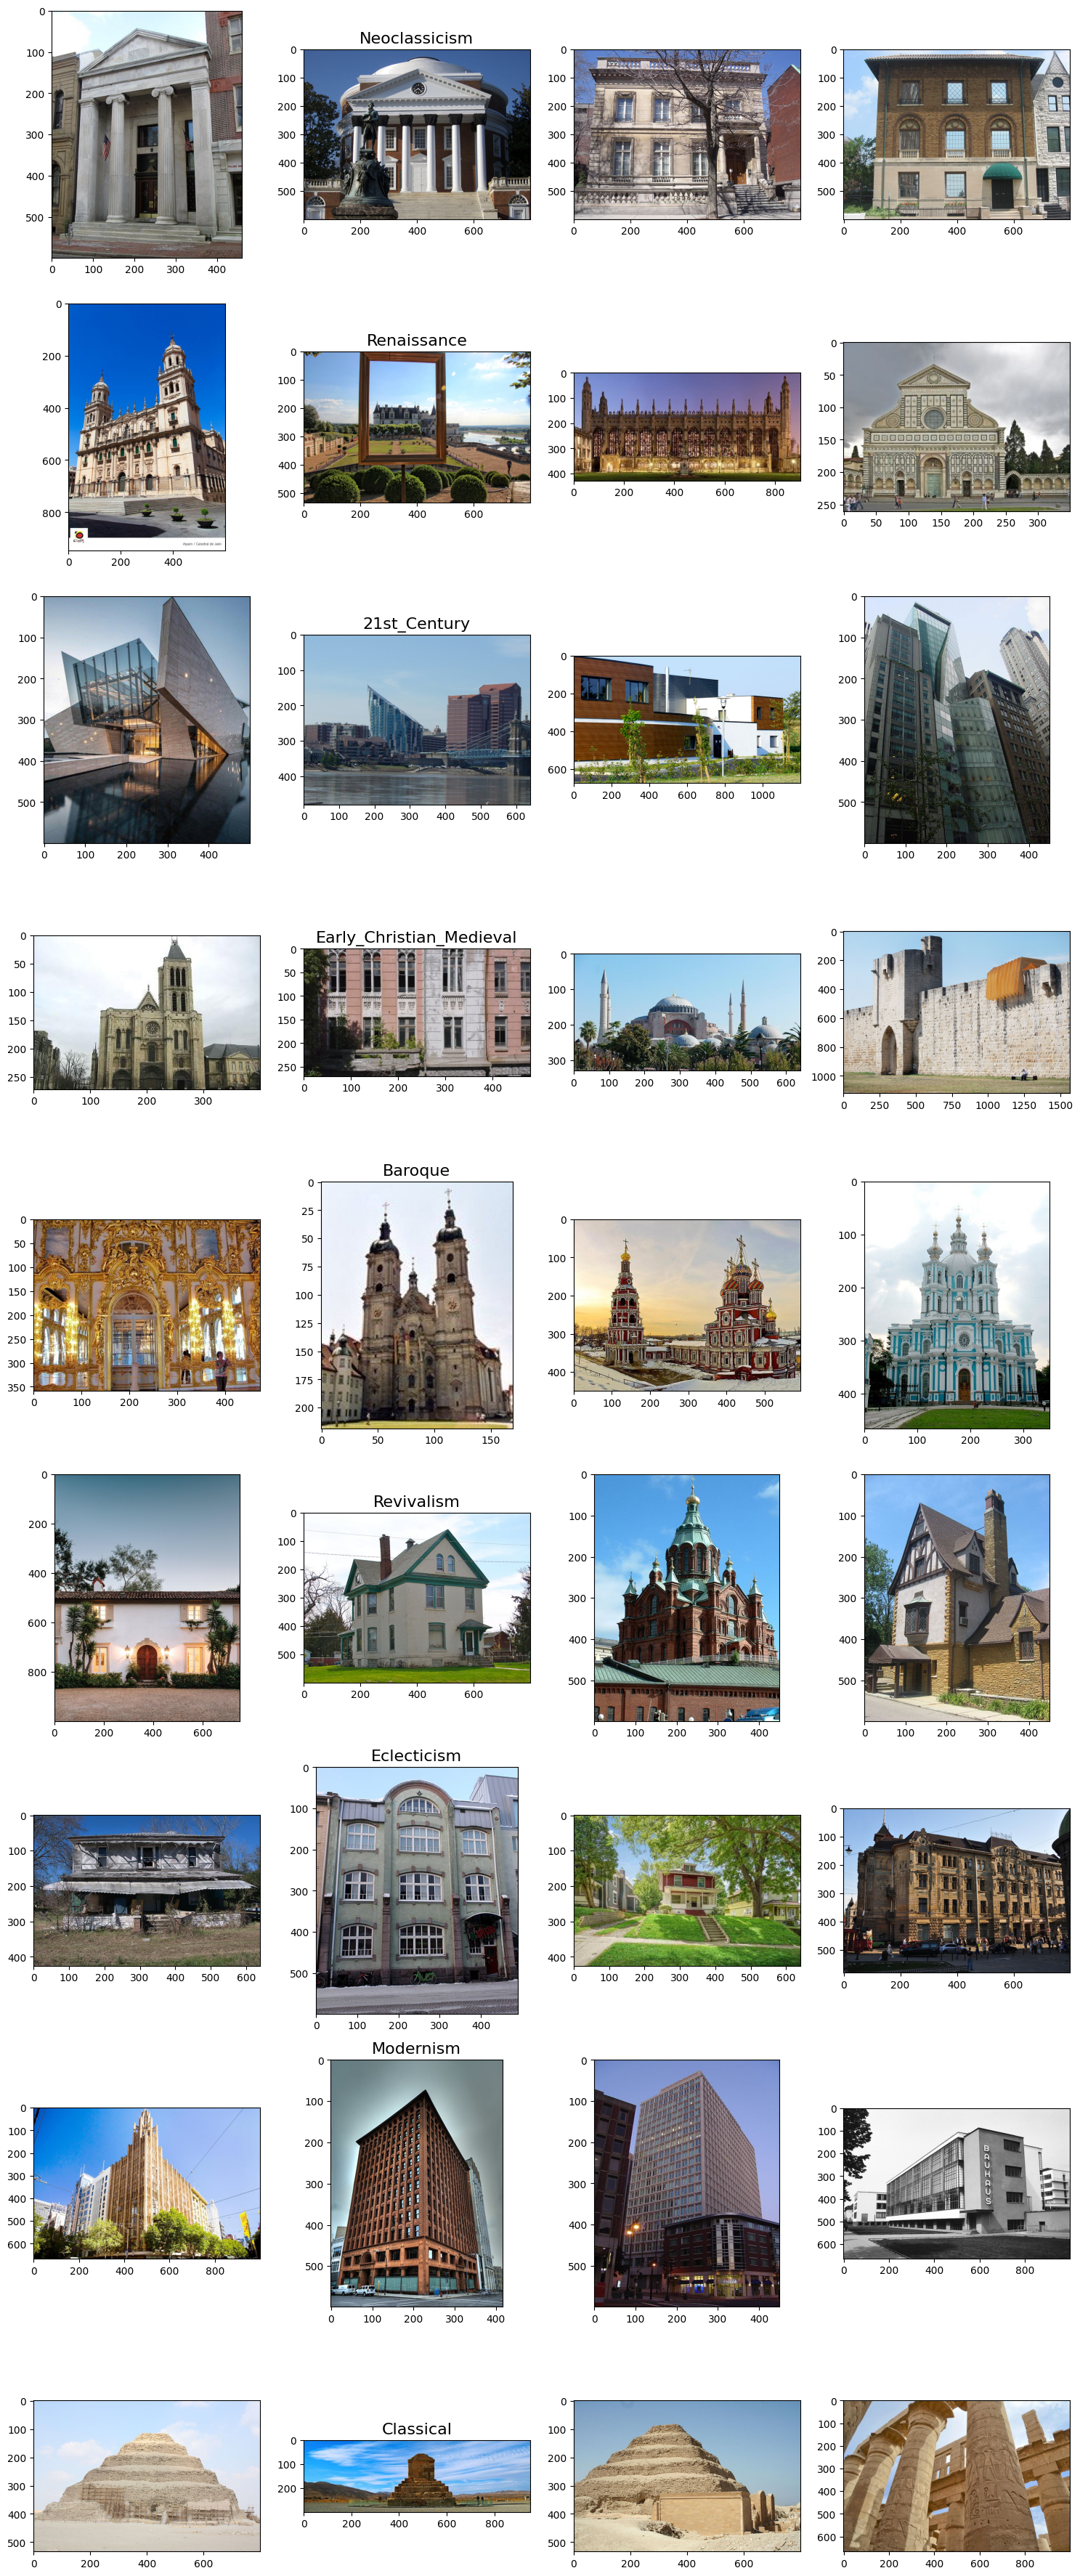

In [25]:
####EDA 2  : 각 클래스별 샘플 이미지 n개씩
def showClassRandomSamples(n):
  # print(merged_data_dir) #/content/data/Merged_dataset/
  class_names =[clas.name for clas in  dataset_path.iterdir()]
  # print(class_names)

  plt.figure(figsize=(15,len(class_names)*n))

  for i, class_name in enumerate(class_names):#enumerate():스트를 돌면서 (순서 인덱스, 값)쌍 반환
    class_path = dataset_path/class_name #ex : ~~/dataset/Classical_Revival
    imgs = [imgfile for imgfile in class_path.iterdir()]
    samples = random.sample(imgs,n)

    for j, img_file in enumerate(samples):
      # print(img_file)
      img = mpimg.imread(img_file)
      plt.subplot(len(class_names),n,i*n+j+1)

      plt.imshow(img)
      if j==1:
        plt.title(class_name, fontsize=16)

  plt.tight_layout()
  plt.show()


###실행
showClassRandomSamples(4)


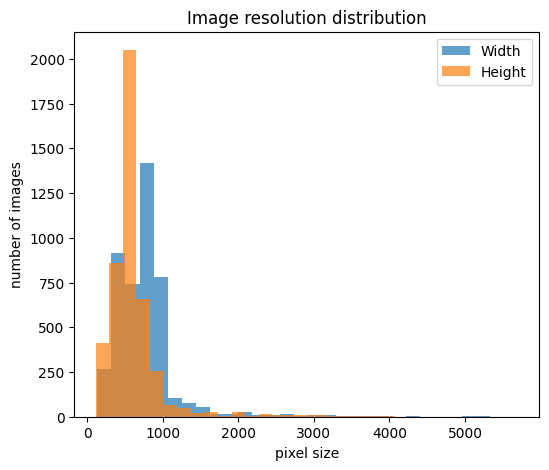

📏 평균 해상도: 773.5 x 620.1
최소 해상도: 134 x 109
최대 해상도: 5705 x 5509


In [118]:
####EDA 3  : 이미지 크기 분포 확인
def showImgSizeDistribution() :
  class_names = [clas.name for clas in  dataset_path.iterdir()]
  img_shapes = []
  error_img = []
  for our_class in class_names:
    folder = os.path.join(dataset_path, our_class) #(예: .../Merged_dataset/21st_Century)
    for img_file in os.listdir(folder):
      img_path = os.path.join(folder, img_file)
      try:
        with Image.open(img_path) as img: #
          img_shapes.append(img.size) #img.size:(width, height) 튜플 반환
      except Exception as e: # Print the error to diagnose
        print(f"Error opening image {img_path}: {e}")
        error_img.append(img_path)


  if not img_shapes: # Check if img_shapes is empty
      print("No image shapes were collected. Please check the error messages above for details.")
  else:
      widths, heights = zip(*img_shapes) #zip(*리스트)는: 리스트 풀어서 끼리끼리 묶어줌 -너비끼리, 높이끼리

      #시각화 - 히스토그램 flt.hist
      plt.figure(figsize=(6,5))
      # bins=30: 데이터를 30개 구간(막대기)으로 나누어 표시
      # alpha=0.7: 막대 투명도를 70%로 설정 (그래프가 겹쳐 보이게 함)
      # label='Width': 범례(legend)에 표시될 이름
      plt.hist(widths, bins=30, alpha=0.7, label='Width')
      plt.hist(heights, bins=30, alpha=0.7, label='Height')

      plt.title('Image resolution distribution')
      plt.xlabel("pixel size")
      plt.ylabel("number of images")
      plt.legend()#범례(label로 지정한 'Width', 'Height')를 표시함

      plt.show()

      print(f"📏 평균 해상도: {np.mean(widths):.1f} x {np.mean(heights):.1f}")
      print(f"최소 해상도: {min(widths)} x {min(heights)}")
      print(f"최대 해상도: {max(widths)} x {max(heights)}")

  if error_img:
      print(f"\n{len(error_img)} images could not be processed:")
      # for err in error_img:
      #     print(err) # Uncomment to print the paths of the problematic images

###실행
showImgSizeDistribution()

In [98]:
## 이미지 수 균일하게 줄이기.
def reductionFiles(numPerClass=500):
  class_img_counts = countImgsPerClass()
  min_img_counts=min(class_img_counts.values())
  print("파일 삭제 전 : ",class_img_counts)

  if min_img_counts<numPerClass:
    print(f"{numPerClass}보다 적은 클래스가 존재합니다.")
    return
  else:
    for class_dir in dataset_path.iterdir():
      class_all_imgs=[f for f in class_dir.iterdir()
                         if f.is_file() and not f.name.startswith('.')]
      random.shuffle(class_all_imgs)
      files_to_delete = class_all_imgs[numPerClass:]#삭제할 파일(500개 초과분)만 선택
      for img_file in files_to_delete:
        img_file.unlink()
  print("파일 삭제 완료")
  return countImgsPerClass()

###실행
reductionFiles()

파일 삭제 전 :  {'Early_Christian_Medieval': 1338, 'Modernism': 1860, 'Neoclassicism': 1225, 'Renaissance': 521, 'Revivalism': 1919, 'Eclecticism': 1315, 'Baroque': 1089, '21st_Century': 1229, 'Classical': 1022}
파일 삭제 완료


{'Early_Christian_Medieval': 500,
 'Modernism': 500,
 'Neoclassicism': 500,
 'Renaissance': 500,
 'Revivalism': 500,
 'Eclecticism': 500,
 'Baroque': 500,
 '21st_Century': 500,
 'Classical': 500}

In [26]:
DATA_DIR = str(dataset_path) #/content/data/Merged_dataset
# print(DATA_DIR)
# 이미지 사이즈/배치/seed (ResNet 등 전이학습 대비 224 권장)
IMG_SIZE = (112, 112)
BATCH_SIZE = 32
SEED = 42 #데이터를 나눌 때 사용할 랜덤 시드
AUTOTUNE = tf.data.AUTOTUNE #tf.data 파이프라인의 성능을 자동으로 최적화

#데이터셋 파이프라인 구축 (Train/Val 분리)
# def createTrainValDatasets():
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,             # 6개 클래스 폴더가 들어있는 상위 폴더
    labels="inferred",    # 폴더명을 라벨로 사용
    label_mode="categorical",      # 원-핫 인코딩 (다중 클래스 분류용)
    validation_split=0.2, # 전체 데이터 중 20%를 검증용으로 validation
    subset="training",    # "나머지 80% -> 훈련용 데이터 training
    seed=SEED,
    image_size=IMG_SIZE,  # 모든 이미지를 자동 리사이징
    batch_size=BATCH_SIZE
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",    # 폴더명을 라벨로 사용
    label_mode="categorical",      # 원-핫 인코딩 (다중 클래스 분류용)
    validation_split=0.2, # 전체 데이터 중 20%를 검증용으로 validation
    subset="validation",    # "나머지 80% -> 훈련용 데이터 training
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
# Keras가 폴더명을 기반으로 자동 생성한 클래스 이름들을 확인.
# (0번 = '21st_Century', 1번 = 'Baroque_Rococo', ... 알파벳 순서로 자동 정렬)
class_names = train_dataset.class_names
print("\n--- 클래스 이름 (자동 생성된 라벨 순서) ---")
print(class_names)
# 파이프라인 최적화(캐시/프리패치)
# - 캐시: 반복(epoch) 시 디스크 재읽기 최소화(메모리에 여유가 있으면 좋음)
# - 프리패치: 다음 배치를 미리 준비하여 GPU/CPU 대기시간 단축
train_dataset = train_dataset.cache().prefetch(AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(AUTOTUNE)



Found 11518 files belonging to 9 classes.
Using 9215 files for training.
Found 11518 files belonging to 9 classes.
Using 2303 files for validation.

--- 클래스 이름 (자동 생성된 라벨 순서) ---
['21st_Century', 'Baroque', 'Classical', 'Early_Christian_Medieval', 'Eclecticism', 'Modernism', 'Neoclassicism', 'Renaissance', 'Revivalism']


In [27]:
# 정규화·증강 레이어 파이프라인에 적용

# def realReadyDataSets():
# train_dataset, val_dataset, class_names=createTrainValDatasets()
###데이터 증강(Augmentation)
#-정규화 레이어: 0~255 픽셀을 0~1로 스케일링
rescale = layers.Rescaling(1./255)
#데이터 증강(Augmentation) 레이어 정의 (학습 데이터에만 적용)
data_augmentation = keras.Sequential(   # 'Sequential' 모델을 사용해 증강 기법들을 파이프라인처럼 만든다.
    [                                   # 훈련 중에 실시간으로 이미지를 변형
        layers.RandomFlip("horizontal"),   # 좌우 뒤집기
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),            # 10% 줌 인/아웃
        layers.RandomContrast(0.1),        # 대비 변화
    ],
    name="data_augmentation"# 이름 붙이기
)
## training학습용 : 증강(data_augmentation) -> 정규화(rescale) 적용
train_dataset_ready = (
    train_dataset
    .map(lambda x, y: (rescale(data_augmentation(x)),y), num_parallel_calls=AUTOTUNE) #x:원본이미지, y:원본레이블
    .prefetch(AUTOTUNE)
)
## 검증용 : 정규화(rescale)만!
val_dataset_ready = (
    val_dataset
    .map( lambda x, y: (rescale(x),y), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)
print("[OK] 파이프라인 준비 완료.")
# return train_dataset_ready, val_dataset_ready, class_names

# 한 배치 꺼내서 모양 확인
print("한 배치 꺼내서 모양 확인")
xb, yb = next(iter(train_dataset_ready))
print("이미지 배치:", xb.shape, xb.dtype)
# 이미지 배치:            예 : (32, 224, 224, 3) <dtype: 'float32'>
# 이미지 배치 (입력 데이터): (배치 크기, 세로px, 가로px, 채널수:rgb) <dtype: 'float32'>
# 의미 : 32장의 224×224 RGB 컬러 이미지

print("라벨 배치 :", yb.shape, yb.dtype)
# 라벨 배치 :            (32, 6) <dtype: 'float32'>
# 라벨 배치 (정답 데이터) : (배치크기, 클래스 수) <dtype: 'float32'>
# 의미 : 6개 클래스 중 해당되는 위치가 1인 one-hot 벡터 ex[0., 0., 0., 0., 1., 0.]


[OK] 파이프라인 준비 완료.
한 배치 꺼내서 모양 확인
이미지 배치: (32, 112, 112, 3) <dtype: 'float32'>
라벨 배치 : (32, 9) <dtype: 'float32'>


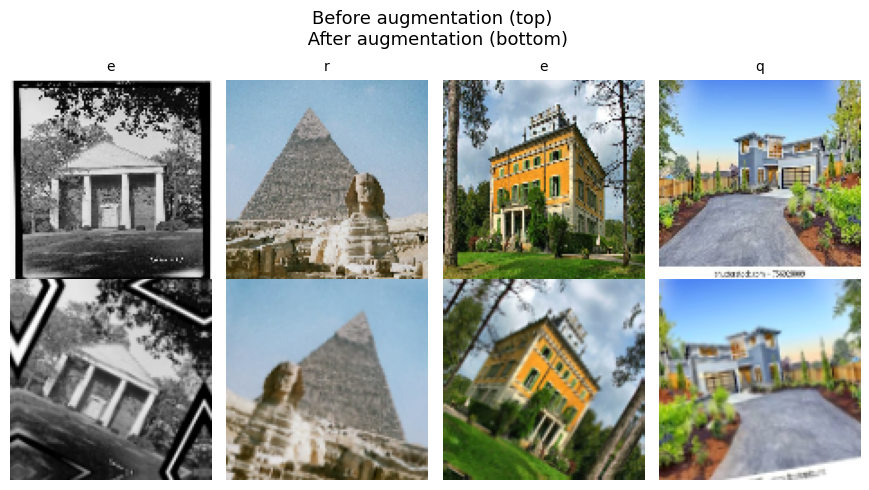

In [28]:

def show_augment_comparison(train_dataset,
                            data_augmentation,
                            class_names=None,
                            max_images=8):
    """
    train_dataset에서 배치 1개를 꺼내 '증강 전/후' 이미지를 8장 비교로 보여줍니다.
    - 위 줄: 증강 전(원본 배치에서 꺼낸 이미지)
    - 아래 줄: 같은 이미지에 data_augmentation을 적용한 결과
    """
    # 배치 하나 추출
    images, labels = next(iter(train_dataset))
    n = min(max_images, images.shape[0])
    images = images[:n]  # (n, H, W, 3)

    # labels가 one-hot이면 argmax로 인덱스 변환
    try:
        label_idx = tf.argmax(labels[:n], axis=1).numpy()
    except Exception:
        # sparse일 수도 있으니 대비
        label_idx = labels[:n].numpy().astype(int).reshape(-1)

    # ----- 증강 적용 (training=True를 명시해서 랜덤 변환 강제) -----
    # 주의: data_augmentation은 정규화 전/후 모두 동작하지만,
    # 보통은 정규화 전 uint8/float32 범위(0~255) 이미지에 적용해도 무방합니다.
    aug_images = data_augmentation(images, training=True)

    # ----- 시각화용 유틸: 값을 0~255로 맞춘 뒤 uint8로 캐스팅 -----
    def to_uint8(x):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        # 만약 0~1 범위라면 255 스케일, 0~255면 그대로 클리핑만
        mx = tf.reduce_max(x)
        x = tf.where(mx <= 1.0, x * 255.0, x)
        x = tf.clip_by_value(x, 0.0, 255.0)
        return tf.cast(x, tf.uint8).numpy()

    vis_orig = to_uint8(images)
    vis_aug  = to_uint8(aug_images)

    # ----- 플로팅 -----
    plt.figure(figsize=(2.2*n, 5))
    # 윗줄: 원본
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(vis_orig[i])
        title = None
        if class_names is not None:
            title = class_names[label_idx[i]]
        if title:
            plt.title(title, fontsize=10)
        plt.axis("off")
    # 아랫줄: 증강 후
    for i in range(n):
        plt.subplot(2, n, n + i + 1)
        plt.imshow(vis_aug[i])
        plt.axis("off")
    plt.suptitle("Before augmentation (top) \n After augmentation (bottom)", fontsize=13)
    plt.tight_layout()
    plt.show()
show_augment_comparison(train_dataset,data_augmentation,'Baroque_Rococo',4 )